<a href="https://colab.research.google.com/github/freshpex/AI-Final-Project/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [162]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
# List of datasets files
datasets = {
    'tesla': '/content/drive/MyDrive/ai_final/tesla.csv',
    'apple': '/content/drive/MyDrive/ai_final/apple.csv',
    'lgtelevision': '/content/drive/MyDrive/ai_final/lgtelevision.csv',
    'netflix': '/content/drive/MyDrive/ai_final/netflix.csv',
    'google': '/content/drive/MyDrive/ai_final/google.csv'
}

# Combine datasets into a single dataframe
combined_dfs = []

for name, path in datasets.items():
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    # Ensure all dates are timezone-naive
    df['Date'] = df['Date'].dt.tz_localize(None)
    df.set_index('Date', inplace=True)
    combined_dfs.append(df)

combined_df = pd.concat(combined_dfs)

# Sort by date
combined_df.sort_index(inplace=True)

combined_df.head(5)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600,0.100323
1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800,0.095089
1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000,0.088110
1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600,0.090291
1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600,0.092908


In [165]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22149 entries, 1980-12-12 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       22149 non-null  float64
 1   High       22149 non-null  float64
 2   Low        22149 non-null  float64
 3   Close      22149 non-null  float64
 4   Volume     22149 non-null  int64  
 5   Adj Close  22149 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.2 MB


In [166]:
combined_df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,22149.000000,22149.000000,22149.000000,22149.000000,2.214900e+04,22149.000000
mean,117.083751,118.543388,115.649940,117.134226,1.571367e+08,116.675467
std,305.751233,309.047220,302.740774,306.019665,2.851121e+08,306.014711
min,0.049665,0.049665,0.049107,0.049107,0.000000e+00,0.038384
25%,0.531250,0.539063,0.520000,0.531250,4.819000e+05,0.443849
50%,9.750000,9.890000,9.500000,9.740000,7.755900e+06,9.500000
75%,39.014999,39.650002,38.457500,39.000000,2.040248e+08,38.230000
max,2524.920000,2526.990000,2498.290000,2521.600000,7.421641e+09,2521.600000


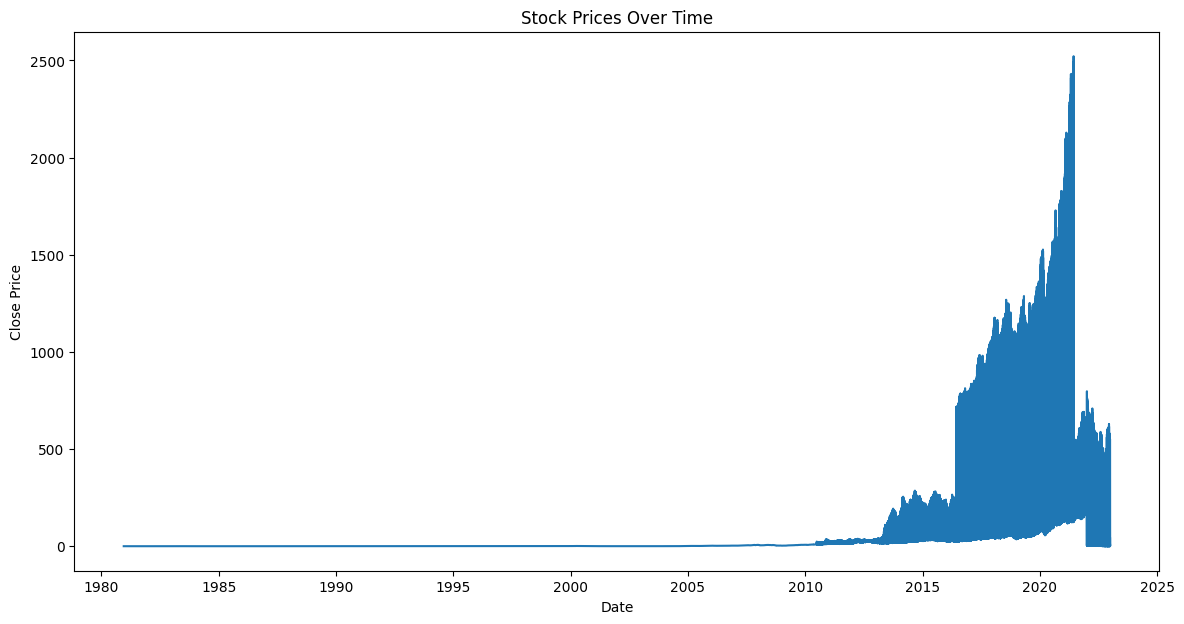

In [183]:
# use pit to visualize stock prices over the time, so we can understand the trends
plt.figure(figsize=(14, 7))
plt.plot(combined_df['Close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**LSTM**

In [168]:
# we want to Normalize the data to make convergence faster
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_df)

**Training** **and** **Testing**

In [169]:
# split the scaled datat into training sets, we are going to use 80 to 20%
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# we are using the inputs to predict the output based on the later days
def create_dataset(data, time_step=1):
    X = []
    y = []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]
        X.append(a)
        y.append(data[i + time_step, 3])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshapes the input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])



**Build and Train**

In [170]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

**Train Model**

In [171]:
# Train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=2)

Epoch 1/5
552/552 - 94s - loss: 0.0105 - 94s/epoch - 170ms/step
Epoch 2/5
552/552 - 85s - loss: 0.0096 - 85s/epoch - 155ms/step
Epoch 3/5
552/552 - 88s - loss: 0.0088 - 88s/epoch - 160ms/step
Epoch 4/5
552/552 - 84s - loss: 0.0086 - 84s/epoch - 152ms/step
Epoch 5/5
552/552 - 86s - loss: 0.0085 - 86s/epoch - 156ms/step


**Plot the Loss**

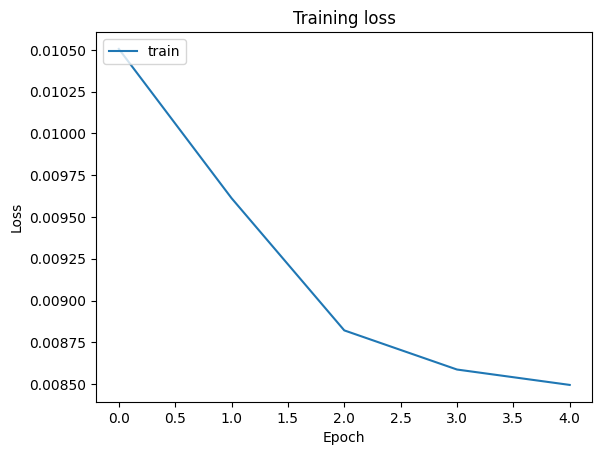

In [172]:
plt.plot(hist.history['loss'])
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper left')
plt.show()

**Predictions**

In [174]:
#train and test the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# since we scaled earlier we need to inverse and transform to get the actual stock prices
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1))[:, 0]



137/137 [==============================] - 7s 54ms/step


**Plot Predictions**

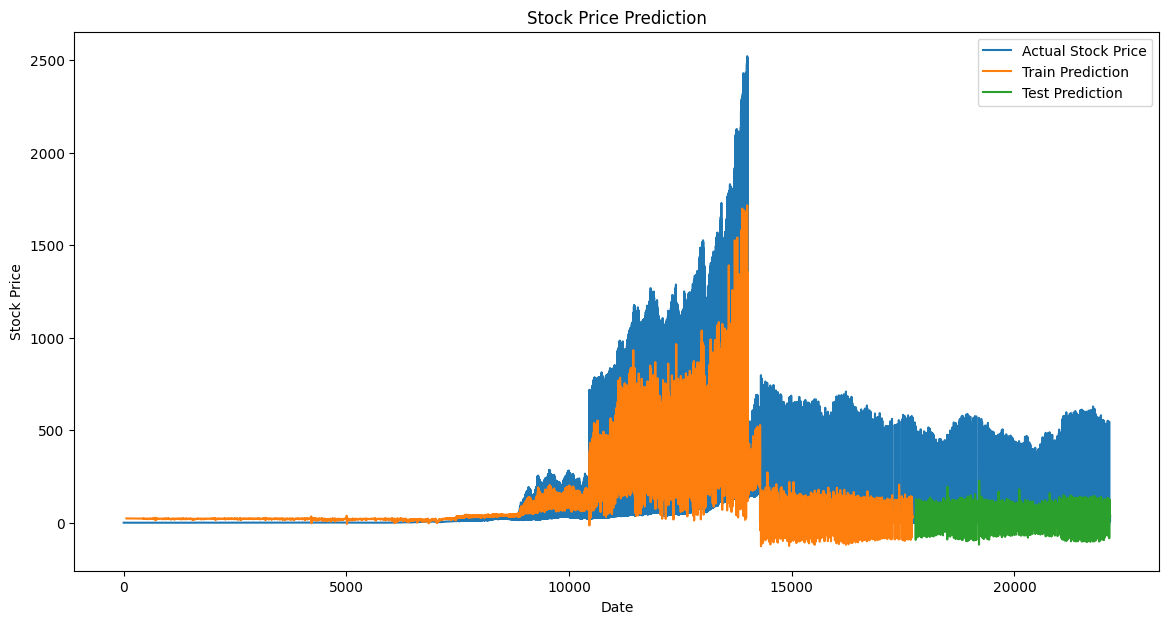

In [175]:
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data[:, 3])
train_predict_plot[:] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data[:, 3])
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data)[:, 3], label='Actual Stock Price')
plt.plot(train_predict_plot, label='Train Prediction')
plt.plot(test_predict_plot, label='Test Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Test Model With a Different Dataset**

In [176]:
# Load a new dataset to test
file = '/content/drive/MyDrive/stock.csv'
testData = pd.read_csv(file)
testData["Date"] = pd.to_datetime(testData["Date"])
testData['Date'] = testData['Date'].dt.tz_localize(None)
testData.set_index('Date', inplace=True)
testData = testData.dropna()

# Normalize the dataset using the same scaler
input_scaled = scaler.transform(testData.values)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [177]:
# Initialize variables for testing
x_test = []
length = len(testData)

# Create input sequences for the test model
for i in range(time_step, length):
    x_test.append(input_scaled[i-time_step:i])

# Convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


In [178]:
# Make predictions
y_pred = model.predict(x_test)

# Inverse transform predictions
predicted_price = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], scaled_data.shape[1]-1)), y_pred), axis=1))[:, -1]

# Get the actual closing prices for comparison
y_test = testData.iloc[time_step:, 3].values


51/51 [==============================] - 3s 52ms/step


**Visualization**

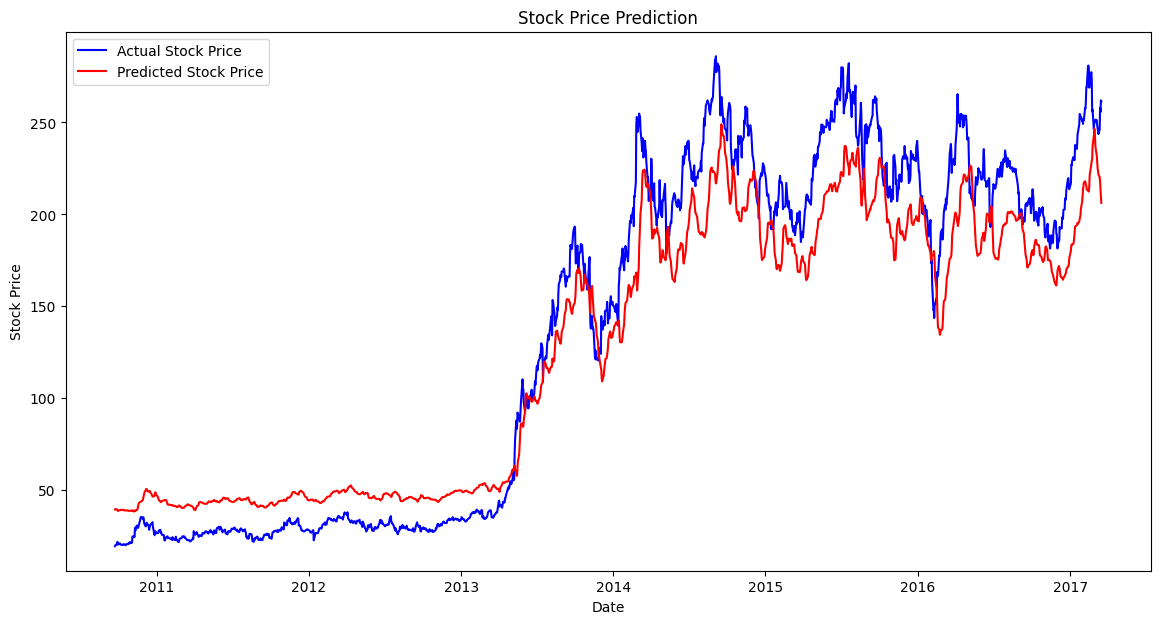

In [179]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(testData.index[time_step:], y_test, color='blue', label='Actual Stock Price')
plt.plot(testData.index[time_step:], predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Performance Metrics**

In [ ]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predicted_price)
rmse = np.sqrt(mse)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")